## Curva de aprendizado

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('resultados/rl_learning_curve.csv')

In [6]:
df['avg_reward'] = df['reward'].expanding().mean()

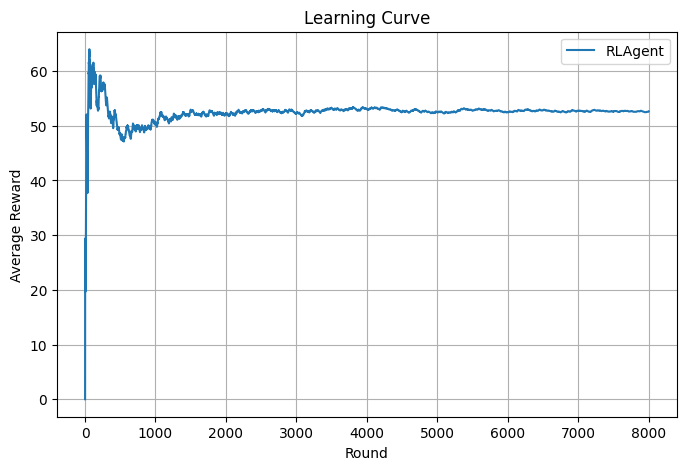

In [7]:
plt.figure(figsize=(8,5))
plt.plot(df['round'], df['avg_reward'], label='RLAgent')
plt.xlabel('Round')
plt.ylabel('Average Reward')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

## GridSearch

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
# import ace_tools as tools 

In [10]:
# Carrega os resultados do grid search
df = pd.read_csv('grid_search_results.csv')

# Ordena por avg_score desc e pega top 10
df_sorted = df.sort_values('avg_score', ascending=False).reset_index(drop=True)
top10 = df_sorted.head(80)

# Imprime a tabela em texto puro
print("\nTop 10 combinações de hiperparâmetros:\n")
print(top10.to_string(index=False))


Top 10 combinações de hiperparâmetros:

 alpha  gamma  epsilon     avg_score
   0.9   0.99     0.05 244205.499324
   0.3   0.99     0.10 243698.169378
   0.7   0.90     0.05 243655.969647
   0.5   0.99     0.10 241910.836431
   0.5   0.99     0.05 241780.415512
   0.5   0.90     0.05 241383.492540
   0.9   0.99     0.01 240403.760937
   0.7   0.99     0.05 239863.007112
   0.1   0.70     0.05 239449.696264
   0.7   0.90     0.10 238240.787238
   0.9   0.99     0.10 237537.318695
   0.9   0.90     0.05 236354.330197
   0.3   0.99     0.20 235963.150758
   0.7   0.99     0.10 235790.563497
   0.7   0.70     0.01 235240.550550
   0.9   0.90     0.01 234255.109200
   0.5   0.99     0.20 233841.274128
   0.7   0.99     0.20 233680.428332
   0.9   0.90     0.10 233062.113598
   0.3   0.99     0.05 232673.635902
   0.9   0.99     0.20 232242.015509
   0.5   0.90     0.20 230701.517938
   0.1   0.90     0.20 230459.916683
   0.5   0.70     0.05 230308.391731
   0.3   0.90     0.20 229958.7173

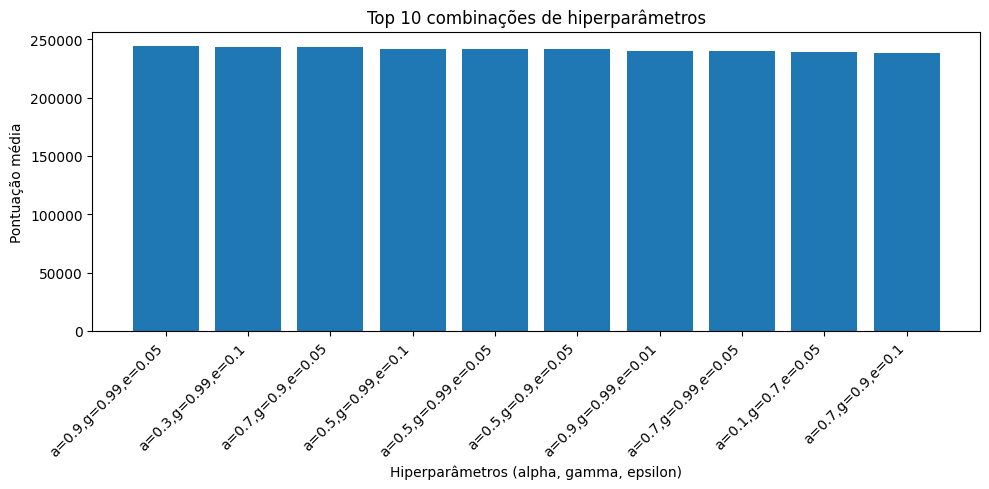

In [7]:
# Plot: barras de avg_score para os top 10
plt.figure(figsize=(10, 5))
plt.bar(
    [f"a={row.alpha},g={row.gamma},e={row.epsilon}" for _, row in top10.iterrows()],
    top10['avg_score']
)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Hiperparâmetros (alpha, gamma, epsilon)')
plt.ylabel('Pontuação média')
plt.title('Top 10 combinações de hiperparâmetros')
plt.tight_layout()
plt.show()